#### IDEA

Use the partecipation described here to check the partecipation of the teams in the global market https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from igraph import Graph
import igraph as ig

In [2]:
leagues = pd.read_csv('resources/club_league.csv')
indexed_leagues = leagues.set_index('club_name')
major_leagues = ['1 Bundesliga', 'Ligue 1', 'Serie A', 'Eredivisie','Premier League', 'Liga Nos', 'Premier Liga', 'Primera Division']

In [3]:
# partecipation as defined in the paper (vectorized using strength matrix)
def get_partecipation(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    sil_total = np.zeros(len(g_teams))
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        sil = s_matrix[:,idx].sum(axis=1)
        sil_total += sil**2
    # compute the partecipation
    P = 1 - sil_total/(g_strengths**2)
    return P                        

In [4]:
# z score as defined in the paper
def get_zscore_paper(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    z_total = np.zeros(len(g_teams))
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        wi = s_matrix[idx,:][:,idx].sum(axis=1)
        z_total[idx] = (wi - wi.mean())/(wi.std()+1.1e-07) # to avoid division by 0
    return z_total

In [5]:
# our variation 
def get_zscore(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    z_total = g_strengths
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        z_total[idx] = (z_total[idx] - g_strengths[idx].mean())/(g_strengths[idx].std()+1.1e-07)
    return z_total

#### Get the mean partecipation for each league

In [86]:
partecipations = {ml:[] for ml in major_leagues}
years = [y for y in range(1992, 2020, 1)]

for year in years:
    
    # get the graph and all the partecipations
    g = Graph.Load('nets/{}/fee_net.net'.format(year))
    Ps = get_partecipation(g)
    
    # divide per league
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g.vs['name']])
    #g_leagues = np.array([indexed_leagues.loc[t].league_name for t in g.vs['name'] if '_seller' not in t])
    for ml in major_leagues:
        ml_P = Ps[np.where(g_leagues==ml)[0]]
        if ml_P.size > 0:
            partecipations[ml].append(ml_P.mean())
        else:
            partecipations[ml].append(0.)

In [87]:
all_p = np.array([partecipations[p] for p in partecipations])
all_p = np.mean(all_p, axis=0)

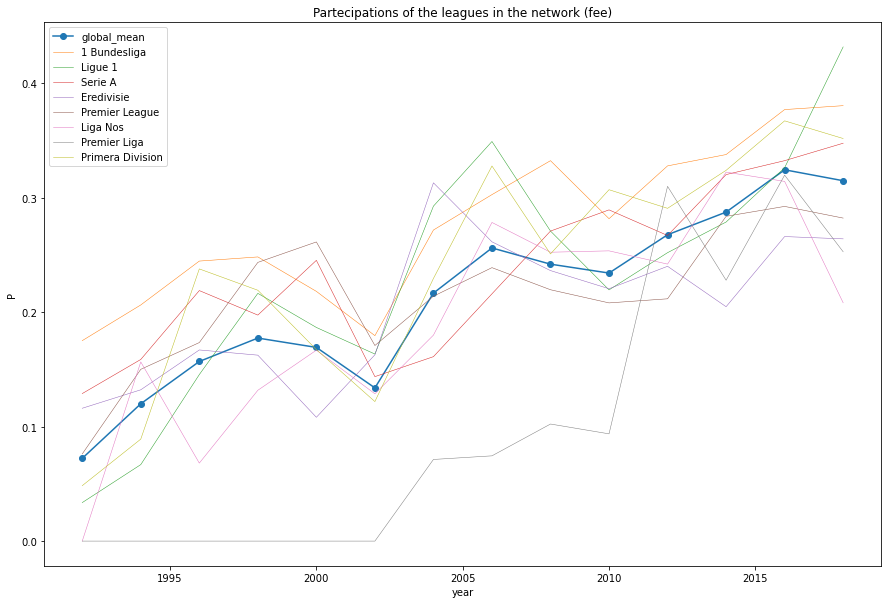

In [88]:
plt.figure(figsize=(15,10))
plt.plot(years[::2], np.mean(np.reshape(all_p,(-1,2)), axis=1), '-o', label='global_mean')
for p in partecipations:
    plt.plot(years[::2], np.mean(np.reshape(partecipations[p],(-1,2)), axis=1), linewidth=0.5, label=p)
    #plt.plot(years, partecipations[p], label=p)

plt.legend()
plt.xlabel('year')
plt.ylabel('P')
plt.title('Partecipations of the leagues in the network (fee)')
plt.savefig('partecipation.png')
plt.show()

#### Look at the roles of the teams

In [101]:
def display_roles(filename, z1=0.8, z2=3, P1=0.4):
    g = Graph.Load(filename)
    names = np.array(g.vs['name'])

    z = get_zscore(g)
    P = get_partecipation(g)
    
    # avoid outliers from 'other' league
    z = z[np.where(z < 6)]
    P = P[np.where(z < 6)]

    int_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P > P1))]
    loc_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P <= P1))]
    int_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P > P1))]
    loc_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P <= P1))]
    int_dom   = names[np.intersect1d(np.where(z > z2), np.where(P > P1))]
    loc_dom   = names[np.intersect1d(np.where(z > z2), np.where(P <= P1))]
    
    
    plt.figure(figsize=(10,7))
    plt.margins(0)
    eps = 0.2
    P_eps = (P1+eps)/(1+eps) 
    plt.scatter(P, z)
    plt.xlim([0-eps, 1])
    plt.axhspan(min(z)-eps, z1, 0, P_eps, facecolor='green', alpha=0.4)
    plt.axhspan(min(z)-eps, z1,P_eps, 1, facecolor='yellow', alpha=0.4)
    plt.axhspan(z1, z2, 0, P_eps, facecolor='blue', alpha=0.4)
    plt.axhspan(z1, z2, P_eps, 1, facecolor='red', alpha=0.4)
    plt.axhspan(z2, max(z)+eps, 0, P_eps, facecolor='brown', alpha=0.4)
    plt.axhspan(z2, max(z)+eps, P_eps, 1, facecolor='gray', alpha=0.4)
    plt.xlabel('P')
    plt.ylabel('z')
    plt.savefig('temp_plot.png')
    plt.show()
    
    print('International dominers: ({}) \n {}'.format(int_dom.size, int_dom))
    print('\nLocal dominers: ({}) \n {}'.format(loc_dom.size, loc_dom))
    print('\nInternational hubs: ({}) \n {}'.format(int_hubs.size, int_hubs))
    print('\nLocal hubs: ({}) \n {}'.format(loc_hubs.size, loc_hubs))
    print('\nInternational clubs: ({}) \n {}'.format(int_clubs.size, int_clubs))
    print('\nLocal clubs: ({}) \n {}'.format(loc_clubs.size, loc_clubs))

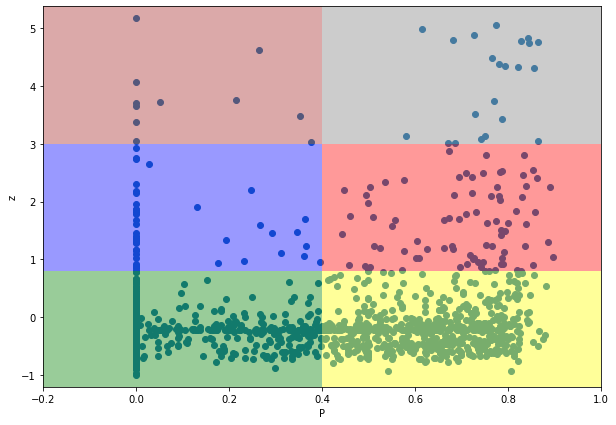

International dominers: (22) 
 ['Borussia Dortmund' 'Real Madrid' 'Bayern Munich' 'FC Barcelona'
 'AS Monaco' 'Paris Saint-Germain' 'FC Internazionale' 'Chelsea FC'
 'Manchester City' 'Manchester United' 'Juventus FC' 'Liverpool FC'
 'Zenit St. Petersburg' 'Borussia Dortmund_seller' 'Twente FC_seller'
 'Ajax Amsterdam_seller' 'AS Monaco_seller' 'Malmö FF_seller'
 'Levski Sofia_seller' 'Atlético Madrid_seller' 'Dnipro_seller'
 'FC Nantes_seller']

Local dominers: (11) 
 ['Nottm Forest_seller' 'QPR_seller' 'Wimbledon FC_seller'
 'Exeter City_seller' 'Piacenza FC_seller' 'Pfeddersheim_seller'
 'Cagliari Calcio_seller' 'FC Haka_seller' 'Herfölge BK_seller'
 'KFC Verbr. Geel_seller' 'AE Larisa_seller']

International hubs: (83) 
 ['Hamburger SV' 'Bayer 04 Leverkusen' 'PSV Eindhoven' 'Ajax Amsterdam'
 'SL Benfica' 'AS Roma' 'Aston Villa' 'Arsenal FC' 'SS Lazio'
 'Tottenham Hotspur' 'Everton FC' 'West Ham United' 'Newcastle United'
 'Valencia CF' 'FC Schalke 04' 'Sevilla FC' 'Olympique Marsei

In [100]:
display_roles('nets/1992-2020/fee_net.net')

In [50]:
def role_percentages(filename, z1=0.8, z2=3, P1=0.4):
    g = Graph.Load(filename)
    names = np.array(g.vs['name'])

    z = get_zscore(g)
    P = get_partecipation(g)

    int_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P > P1))]
    loc_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P <= P1))]
    int_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P > P1))]
    loc_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P <= P1))]
    int_dom   = names[np.intersect1d(np.where(z > z2), np.where(P > P1))]
    loc_dom   = names[np.intersect1d(np.where(z > z2), np.where(P <= P1))]
    
    roles_lengths = [len(int_clubs), len(loc_clubs),len(int_hubs),len(loc_hubs),len(int_dom),len(loc_dom)]
    percentages = np.array(roles_lengths)/len(names)*100
    return percentages

In [91]:
years = [y for y in range(1992, 2020, 1)]
percentages = {'int_clubs':[], 'loc_clubs':[],'int_hubs':[],'loc_hubs':[],'int_dom':[],'loc_dom':[]}
for year in years:
    p = role_percentages('nets/{}/freq_net.net'.format(year))
    for i,role in enumerate(percentages):
        percentages[role].append(p[i])

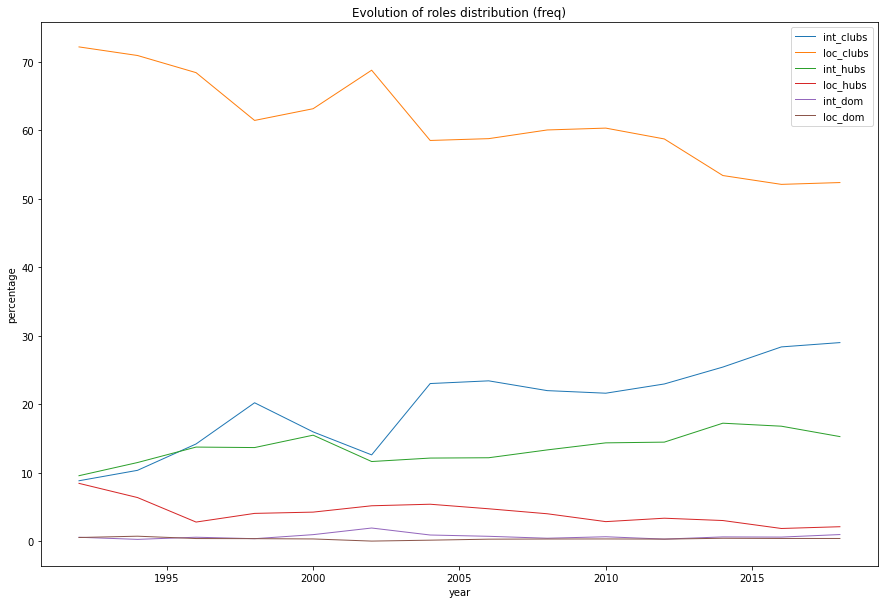

In [92]:
plt.figure(figsize=(15,10))
for role in percentages:
    plt.plot(years[::2], np.mean(np.reshape(percentages[role],(-1,2)), axis=1), linewidth=1, label=role)
    #plt.plot(years, percentages[role], linewidth=1, label=role)

plt.legend()
plt.xlabel('year')
plt.ylabel('percentage')
plt.title('Evolution of roles distribution (freq)')
plt.savefig('roles.png')
plt.show()